In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from constants import ROOT_DIR

# Lecture des fichiers

## Content
The dataset contains a sample of user interactions (page views) in G1 news portal from Oct. 1 to 16, 2017, including about 3 million clicks, distributed in more than 1 million sessions from 314,000 users who read more than 46,000 different news articles during that period.

It is composed by three files/folders:
- clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.
- articles_metadata.csv - CSV file with metadata information about all (364047) published articles
- articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.


P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.


In [2]:
DATA_DIR = ROOT_DIR / "data"
CLICKS_DIR = DATA_DIR / "unzip_clicks"
WORK_DIR = DATA_DIR / "workbase"

## Clicks.zip


In [3]:
# List every file in the clicks directory with glob
clicks_files = glob(str(CLICKS_DIR / "*.csv"))
n_hours = len(clicks_files)
print(f"Number of hours of clicks data: {n_hours}")
print(f"Number of days of clicks data: {n_hours // 24}")

Number of hours of clicks data: 385
Number of days of clicks data: 16


In [4]:
# Read all CSV files into a list of DataFrames
clicks_dfs = [pd.read_csv(file) for file in clicks_files]
# Concatenate all DataFrames into a single DataFrame
clicks_df = pd.concat(clicks_dfs, ignore_index=True)
print(f"Shape of concatenated clicks DataFrame: {clicks_df.shape}")

Shape of concatenated clicks DataFrame: (2988181, 12)


In [5]:
print(clicks_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB
None


In [6]:
clicks_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,51518,1508150180222851,1508150180000,2,336254,1508151096676,4,1,17,1,9,2
1,51518,1508150180222851,1508150180000,2,157478,1508151126676,4,1,17,1,9,2
2,5518,1508150180837852,1508150180000,3,207603,1508150468546,4,1,17,1,20,1
3,5518,1508150180837852,1508150180000,3,272802,1508150616670,4,1,17,1,20,1
4,5518,1508150180837852,1508150180000,3,158179,1508150646670,4,1,17,1,20,1


In [7]:
# Define timestamps columns
timestamp_cols = ["session_start", "click_timestamp"]

# Convert timestamp columns to datetime and numeric types to best integer type to save memory
clicks_df = clicks_df.assign(
    **{
        col: lambda df, col=col: pd.to_datetime(df[col], unit="ms")
        for col in timestamp_cols
    }
).assign(
    **{
        col: lambda df, col=col: pd.to_numeric(df[col], downcast="integer")
        for col in clicks_df.columns
        if col not in timestamp_cols
    }
)

In [8]:
# Quick health check about missing values
print("Missing values in clicks DataFrame:")
print(clicks_df.isnull().sum())

Missing values in clicks DataFrame:
user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64


In [9]:
# Quick health check about duplicates
print("Number of duplicate rows in clicks DataFrame:")
print(clicks_df.duplicated().sum())

Number of duplicate rows in clicks DataFrame:
0


In [10]:
print("Unique values in columns of clicks DataFrame:")
for col in clicks_df:
    print(f"'{col}': {clicks_df[col].nunique()}")

Unique values in columns of clicks DataFrame:
'user_id': 322897
'session_id': 1048594
'session_start': 646874
'session_size': 72
'click_article_id': 46033
'click_timestamp': 2983198
'click_environment': 3
'click_deviceGroup': 5
'click_os': 8
'click_country': 11
'click_region': 28
'click_referrer_type': 7


In [11]:
print(clicks_df.describe())

            user_id    session_id                  session_start  \
count  2.988181e+06  2.988181e+06                        2988181   
mean   1.079478e+05  1.507472e+15  2017-10-08 14:17:08.013158144   
min    0.000000e+00  1.506825e+15            2017-10-01 02:37:03   
25%    4.034100e+04  1.507124e+15            2017-10-04 13:35:52   
50%    8.622900e+04  1.507493e+15            2017-10-08 20:09:00   
75%    1.632610e+05  1.507749e+15            2017-10-11 19:16:54   
max    3.228960e+05  1.508211e+15            2017-10-17 03:36:19   
std    8.364836e+04  3.855245e+11                            NaN   

       session_size  click_article_id                click_timestamp  \
count  2.988181e+06      2.988181e+06                        2988181   
mean   3.901885e+00      1.949226e+05  2017-10-08 14:51:05.606099456   
min    2.000000e+00      3.000000e+00     2017-10-01 03:00:00.026000   
25%    2.000000e+00      1.242280e+05  2017-10-04 14:20:52.854000128   
50%    3.000000e+00      2.

In [12]:
# Check that every user_id has a unique session_id or more
assert (
    clicks_df.duplicated(subset=["user_id", "session_id"], keep=False).sum()
    == clicks_df.shape[0]
), "There are users with multiple session_ids, which is unexpected."

In [13]:
clicks_df.groupby("user_id")["session_id"].nunique().describe()

count    322897.000000
mean          3.247457
std           3.804315
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         207.000000
Name: session_id, dtype: float64

<Axes: title={'center': 'Number of unique session_ids per user_id clipped at 99th percentile'}, xlabel='num_sessions_id'>

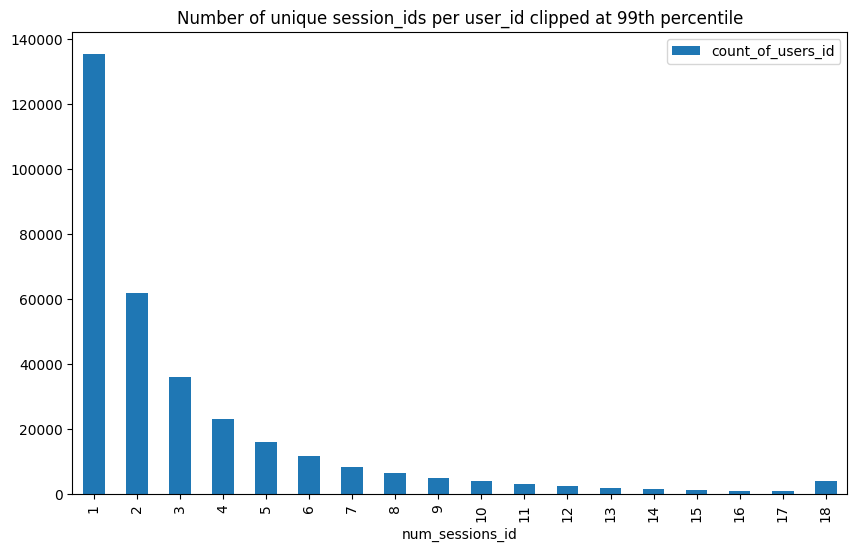

In [14]:
unique_sessions = clicks_df.groupby("user_id")["session_id"].nunique()
upper_bound = unique_sessions.quantile(0.99)
unique_sessions.clip(upper=upper_bound).value_counts().reset_index().rename(
    {"count": "count_of_users_id", "session_id": "num_sessions_id"}, axis=1
).set_index("num_sessions_id").sort_index().plot(
    kind="bar",
    figsize=(10, 6),
    title="Number of unique session_ids per user_id clipped at 99th percentile",
)

In [15]:
print(
    "Can a user can have read the same article id multiple times in a session?"
    "\n===================================================================="
)
print(
    clicks_df.groupby(["user_id", "session_id", "click_article_id"])
    .size()
    .reset_index(name="count")
    .groupby("count")
    .size()
    .rename_axis(
        "N_times | Count of users who have clicked on the same article id once or more times in the same session",
        axis=0,
    ),
)
print("Answer: No, one article has not been read twice in the same session.")

Can a user can have read the same article id multiple times in a session?
N_times | Count of users who have clicked on the same article id once or more times in the same session
1    2988181
dtype: int64
Answer: No, one article has not been read twice in the same session.


In [16]:
print(
    "Can a user can have read the same article id multiple times through different sessions?"
    "\n======================================================================================="
)
print(
    clicks_df.groupby(["user_id", "click_article_id"])
    .size()
    .reset_index(name="count")
    .groupby("count")
    .size()
    .rename_axis(
        "N_times | Count of users who have clicked on the same article id once or more times through different sessions",
        axis=0,
    ),
)
print(
    "Answer: yes, they can read the same article multiple times through multiple sessions."
)

Can a user can have read the same article id multiple times through different sessions?
N_times | Count of users who have clicked on the same article id once or more times through different sessions
1     2916835
2       31459
3        1869
4         343
5          95
6          42
7          22
8          14
9           7
10          7
12          3
13          6
16          2
17          1
30          1
31          1
33          3
dtype: int64
Answer: yes, they can read the same article multiple times through multiple sessions.


In [17]:
# Sanity check that each session_id has a unique session_size
clicks_df.groupby("session_id")["session_size"].nunique().value_counts()

session_size
1    1048594
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of session_size'}, xlabel='Session size (number of clicks)', ylabel='Count of sessions'>

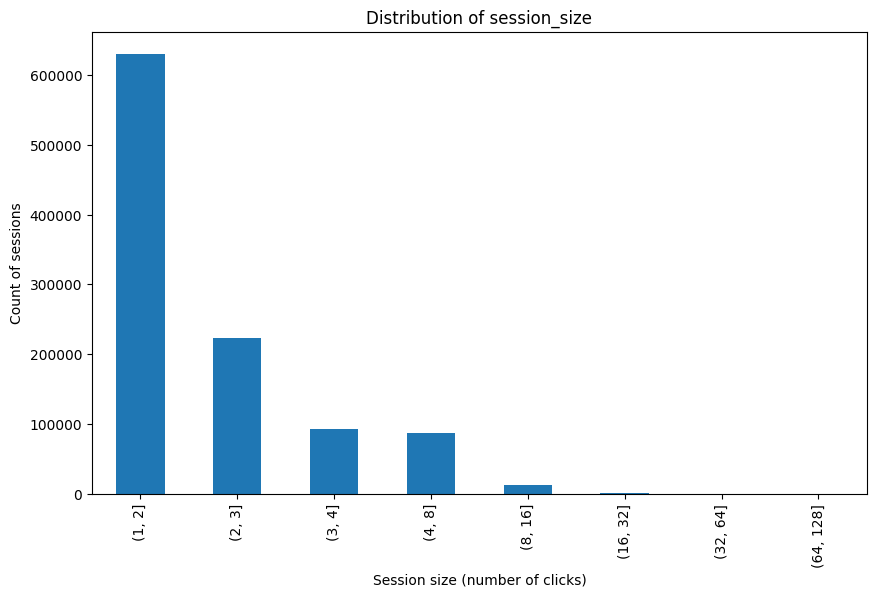

In [18]:
pd.cut(
    clicks_df.groupby("session_id")["session_size"].first(),
    bins=[1, 2, 3, 4, 8, 16, 32, 64, 128],
).value_counts().sort_index().plot.bar(
    title="Distribution of session_size",
    xlabel="Session size (number of clicks)",
    ylabel="Count of sessions",
    figsize=(10, 6),
)

In [19]:
clicks_df.groupby("session_id")["session_size"].first()

session_id
1506825423271737    2
1506825426267738    2
1506825435299739    2
1506825442704740    2
1506825528135741    2
                   ..
1508211367250326    2
1508211369104327    7
1508211372158328    2
1508211376302329    2
1508211379189330    2
Name: session_size, Length: 1048594, dtype: int8

In [20]:
clicks_df["session_size"].describe()

count    2.988181e+06
mean     3.901885e+00
std      3.929941e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.240000e+02
Name: session_size, dtype: float64

<Axes: title={'center': 'Distribution of session_size (number of clicks per session)'}, xlabel='Session size', ylabel='Count'>

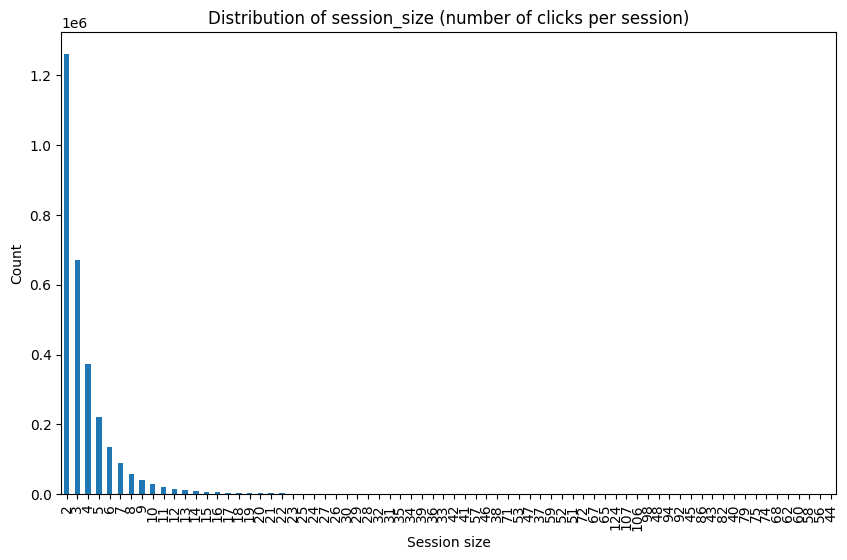

In [21]:
clicks_df["session_size"].value_counts().plot.bar(
    title="Distribution of session_size (number of clicks per session)",
    xlabel="Session size",
    ylabel="Count",
    figsize=(10, 6),
)

In [22]:
print(
    "Can a user can click from one environment to another one in the same session?"
    "\n===================================================================="
)
print(
    clicks_df.groupby(["user_id", "session_id"])["click_environment"]
    .nunique()
    .value_counts()
)
print("Answer: yes but in some very rare cases.")

Can a user can click from one environment to another one in the same session?
click_environment
1    1048106
2        488
Name: count, dtype: int64
Answer: yes but in some very rare cases.


### TIMESTAMP COLUMNS

Les colonnes de type `timestamp` ne devraient pas être forcément triés par ordre croissant du fait qu'ils sont regroupés par utilisateur.

In [23]:
for col in timestamp_cols:
    # Check that the timestamps are in ascending order
    print(f"{col} is monotonic increasing: {clicks_df[col].is_monotonic_increasing}")

session_start is monotonic increasing: False
click_timestamp is monotonic increasing: False


In [24]:
print("Descriptive statistics for timestamp columns:")
print(clicks_df.filter(timestamp_cols).describe())

Descriptive statistics for timestamp columns:
                       session_start                click_timestamp
count                        2988181                        2988181
mean   2017-10-08 14:17:08.013158144  2017-10-08 14:51:05.606099456
min              2017-10-01 02:37:03     2017-10-01 03:00:00.026000
25%              2017-10-04 13:35:52  2017-10-04 14:20:52.854000128
50%              2017-10-08 20:09:00  2017-10-08 20:35:30.480999936
75%              2017-10-11 19:16:54  2017-10-11 19:43:24.600999936
max              2017-10-17 03:36:19     2017-11-13 20:04:14.886000


In [26]:
clicks_df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,51518,1508150180222851,2017-10-16 10:36:20,2,336254,2017-10-16 10:51:36.676,4,1,17,1,9,2
1,51518,1508150180222851,2017-10-16 10:36:20,2,157478,2017-10-16 10:52:06.676,4,1,17,1,9,2
2,5518,1508150180837852,2017-10-16 10:36:20,3,207603,2017-10-16 10:41:08.546,4,1,17,1,20,1
3,5518,1508150180837852,2017-10-16 10:36:20,3,272802,2017-10-16 10:43:36.670,4,1,17,1,20,1
4,5518,1508150180837852,2017-10-16 10:36:20,3,158179,2017-10-16 10:44:06.670,4,1,17,1,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,130833,1507797368158503,2017-10-12 08:36:08,2,233688,2017-10-12 08:43:21.031,4,3,2,1,21,2
2988177,130833,1507797368158503,2017-10-12 08:36:08,2,111043,2017-10-12 08:43:51.031,4,3,2,1,21,2
2988178,218780,1507797375236504,2017-10-12 08:36:15,3,208150,2017-10-12 08:36:49.719,4,3,2,1,5,1
2988179,218780,1507797375236504,2017-10-12 08:36:15,3,202670,2017-10-12 08:40:52.043,4,3,2,1,5,1


In [30]:
clicks_df.assign(date=lambda x: x["click_timestamp"].dt.date)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,date
0,51518,1508150180222851,2017-10-16 10:36:20,2,336254,2017-10-16 10:51:36.676,4,1,17,1,9,2,2017-10-16
1,51518,1508150180222851,2017-10-16 10:36:20,2,157478,2017-10-16 10:52:06.676,4,1,17,1,9,2,2017-10-16
2,5518,1508150180837852,2017-10-16 10:36:20,3,207603,2017-10-16 10:41:08.546,4,1,17,1,20,1,2017-10-16
3,5518,1508150180837852,2017-10-16 10:36:20,3,272802,2017-10-16 10:43:36.670,4,1,17,1,20,1,2017-10-16
4,5518,1508150180837852,2017-10-16 10:36:20,3,158179,2017-10-16 10:44:06.670,4,1,17,1,20,1,2017-10-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,130833,1507797368158503,2017-10-12 08:36:08,2,233688,2017-10-12 08:43:21.031,4,3,2,1,21,2,2017-10-12
2988177,130833,1507797368158503,2017-10-12 08:36:08,2,111043,2017-10-12 08:43:51.031,4,3,2,1,21,2,2017-10-12
2988178,218780,1507797375236504,2017-10-12 08:36:15,3,208150,2017-10-12 08:36:49.719,4,3,2,1,5,1,2017-10-12
2988179,218780,1507797375236504,2017-10-12 08:36:15,3,202670,2017-10-12 08:40:52.043,4,3,2,1,5,1,2017-10-12


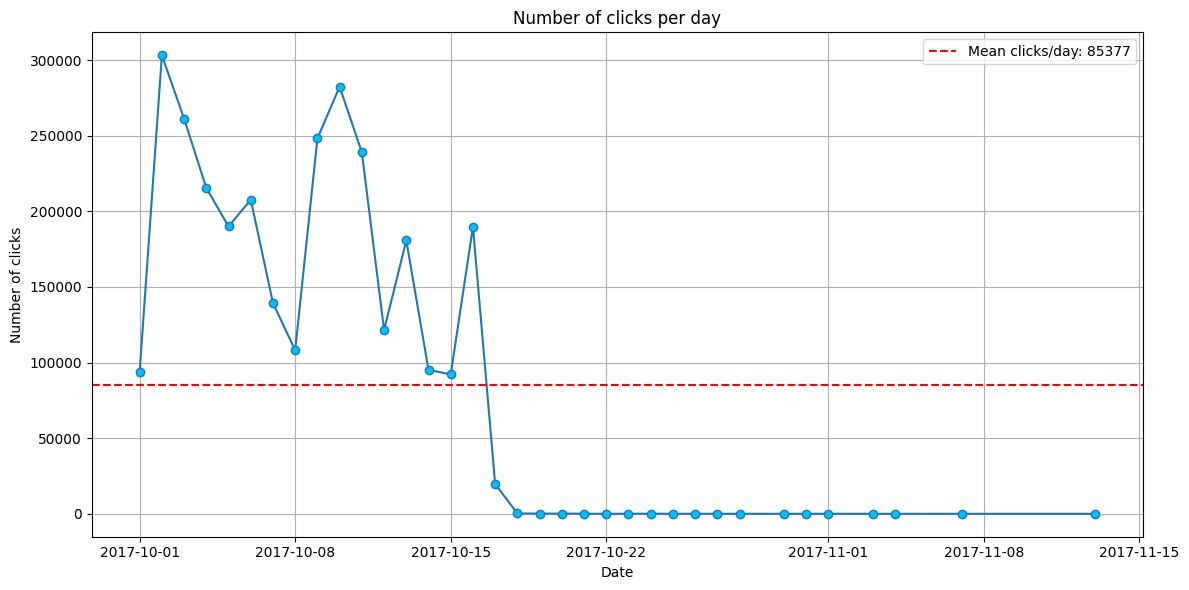

In [32]:
clicks_df.assign(date=lambda x: x["click_timestamp"].dt.date).groupby(
    "date"
).size().plot(
    kind="line",
    figsize=(12, 6),
    title="Number of clicks per day",
    xlabel="Date",
    ylabel="Number of clicks",
    marker="o",
    markersize=6,
    markerfacecolor="deepskyblue",
)
# Compute the mean number of clicks per day
mean_daily_clicks = (
    clicks_df.assign(date=lambda x: x["click_timestamp"].dt.date)
    .groupby("date")
    .size()
    .mean()
)
# add a horizontal line at the mean
plt.axhline(
    mean_daily_clicks,
    color="red",
    linestyle="--",
    label=f"Mean clicks/day: {mean_daily_clicks:.0f}",
)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Analyse du nombre de clics par jour

La courbe montre l’évolution du nombre de clics enregistrés chaque jour sur la période observée.

- **Début de période (1er au 16 octobre 2017)** :  
  On observe une forte activité, avec des pics dépassant les 300 000 clics certains jours. La majorité des jours présentent un volume de clics bien supérieur à la moyenne (indiquée par la ligne rouge pointillée à environ 85 000 clics/jour).

- **Après le 16 octobre 2017** :  
  Le nombre de clics chute brutalement à des valeurs proches de zéro et reste très faible ou nul jusqu’à la fin de la période affichée. Cela suggère une interruption ou un arrêt de la collecte des données à partir de cette date.

- **Variabilité avant le 16 octobre** :  
  On note des fluctuations importantes d’un jour à l’autre, ce qui peut refléter des variations naturelles d’audience (jours de semaine vs week-end, événements particuliers, etc.) ou des irrégularités dans la collecte.

- **Moyenne journalière** :  
  La ligne rouge représente la moyenne du nombre de clics par jour. Avant le 16 octobre, la plupart des jours sont au-dessus de cette moyenne, ce qui indique que la moyenne est tirée vers le bas par les nombreux jours à zéro après cette date.

---

**Conclusion :**  
- La collecte de données semble complète et fiable uniquement sur la première moitié du mois d’octobre 2017.
- Les jours suivants doivent probablement être exclus des analyses, car ils ne reflètent pas l’activité réelle des utilisateurs.
- Il sera important de filtrer ou d’annoter ces périodes lors de la préparation des données pour éviter des biais dans les analyses ou la modélisation.

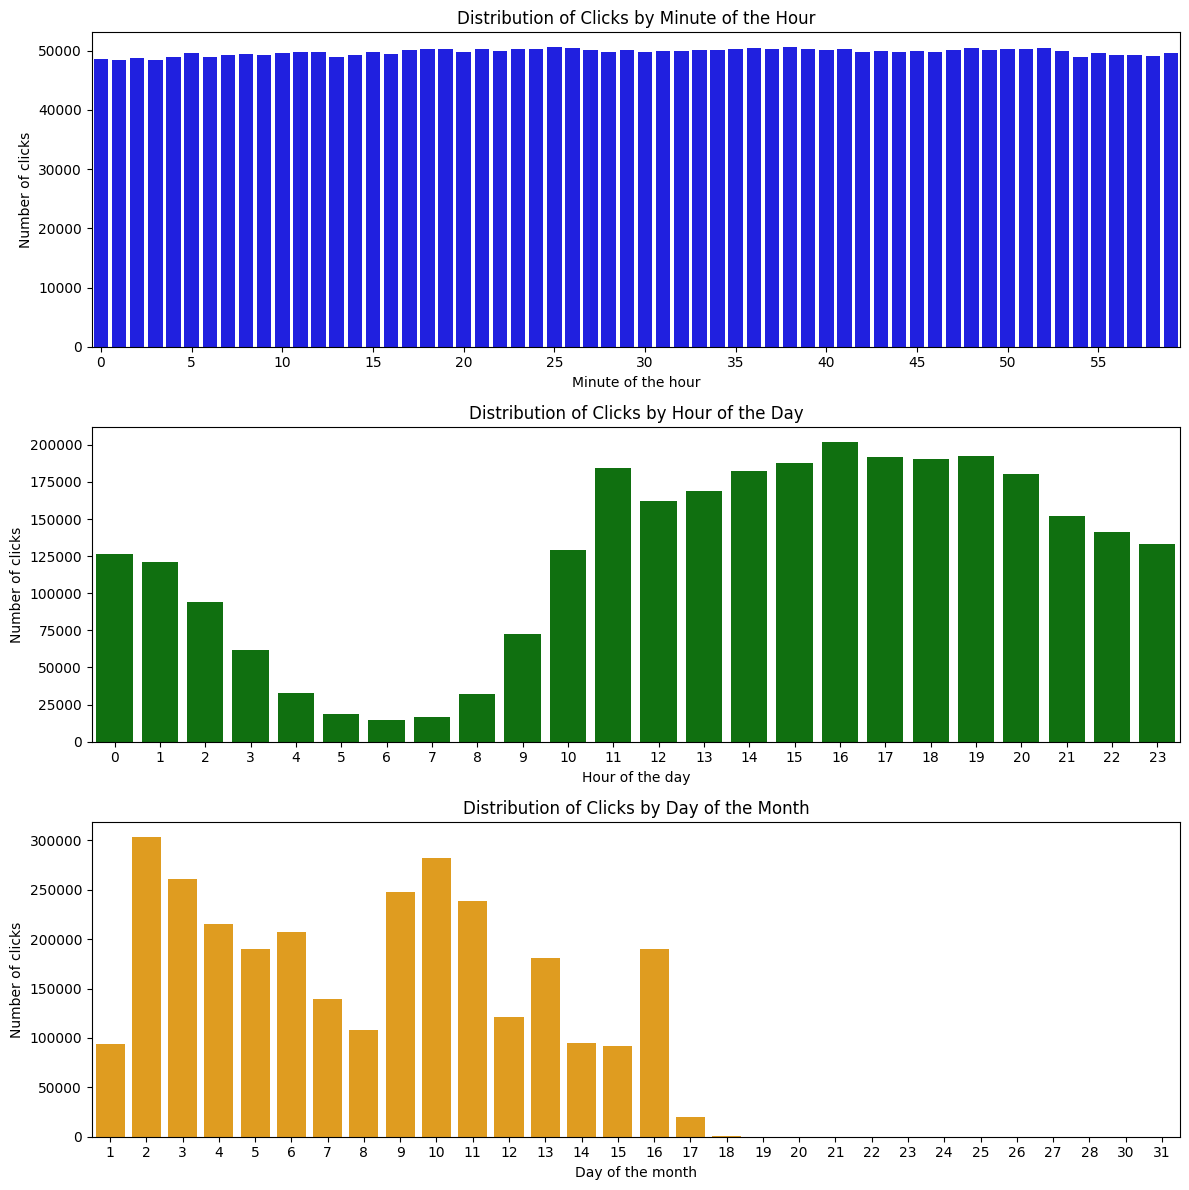

In [33]:
clicks_df = clicks_df.assign(
    **{
        "click_timestamp_M": lambda df: df["click_timestamp"].dt.minute,
        "click_timestamp_H": lambda df: df["click_timestamp"].dt.hour,
        "click_timestamp_D": lambda df: df["click_timestamp"].dt.day,
    }
)

#
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
# Plot countplots of click timestamps by minute, hour, and day
sns.countplot(
    data=clicks_df,
    x="click_timestamp_M",
    ax=ax[0],
    color="blue",
)
ax[0].set(
    xlabel="Minute of the hour",
    ylabel="Number of clicks",
    title="Distribution of Clicks by Minute of the Hour",
    xticks=range(0, 60, 5),
)

sns.countplot(
    data=clicks_df,
    x="click_timestamp_H",
    ax=ax[1],
    color="green",
)
ax[1].set(
    xlabel="Hour of the day",
    ylabel="Number of clicks",
    title="Distribution of Clicks by Hour of the Day",
)

sns.countplot(
    data=clicks_df,
    x="click_timestamp_D",
    ax=ax[2],
    color="orange",
)
ax[2].set(
    xlabel="Day of the month",
    ylabel="Number of clicks",
    title="Distribution of Clicks by Day of the Month",
)
plt.tight_layout()
plt.show()

### Analyse des distributions temporelles des clics

**1. Par minute de l’heure**  
La distribution des clics par minute est très homogène, sans variation notable. Cela indique que les clics sont répartis uniformément au sein de chaque heure, sans effet de bord particulier (pas de pic en début ou fin d’heure).

**2. Par heure de la journée**  
On observe une forte variation selon l’heure :  
- Très peu de clics entre 3h et 8h du matin (activité nocturne faible).
- Forte augmentation à partir de 9h, avec un pic entre 16h et 19h.
- L’activité reste élevée jusqu’à 21h, puis diminue progressivement.
Cela reflète des habitudes classiques de consultation, avec une activité maximale en fin d’après-midi et début de soirée.

**3. Par jour du mois**  
La répartition par jour montre des variations importantes :  
- Certains jours (ex : 1, 2, 10, 11) présentent beaucoup plus de clics que d’autres.
- Quelques jours (fin de mois) ont très peu de clics, ce qui peut indiquer une période de collecte incomplète ou des jours manquants dans le dataset.
- Il peut aussi y avoir des effets de week-end ou d’événements particuliers.

---

**Conclusion :**  
- Les clics sont uniformément répartis dans chaque heure.
- L’activité dépend fortement de l’heure de la journée, avec un pic en fin d’après-midi.
- La collecte par jour n’est pas homogène, il faudra en tenir compte pour l’analyse ou la modélisation (éventuellement filtrer les jours incomplets).

Après analyse du dataframe, voici quelques annotations utiles sur les colonnes :
- `user_id` : Identifiant unique de l'utilisateur. 322897 utilisateurs uniques.
- `session_id` : Basé sur le timestamp de session et différencié par utilisateur. Unique par utilisateur.
- `session_start` : Timestamp de la session, au format Unix.

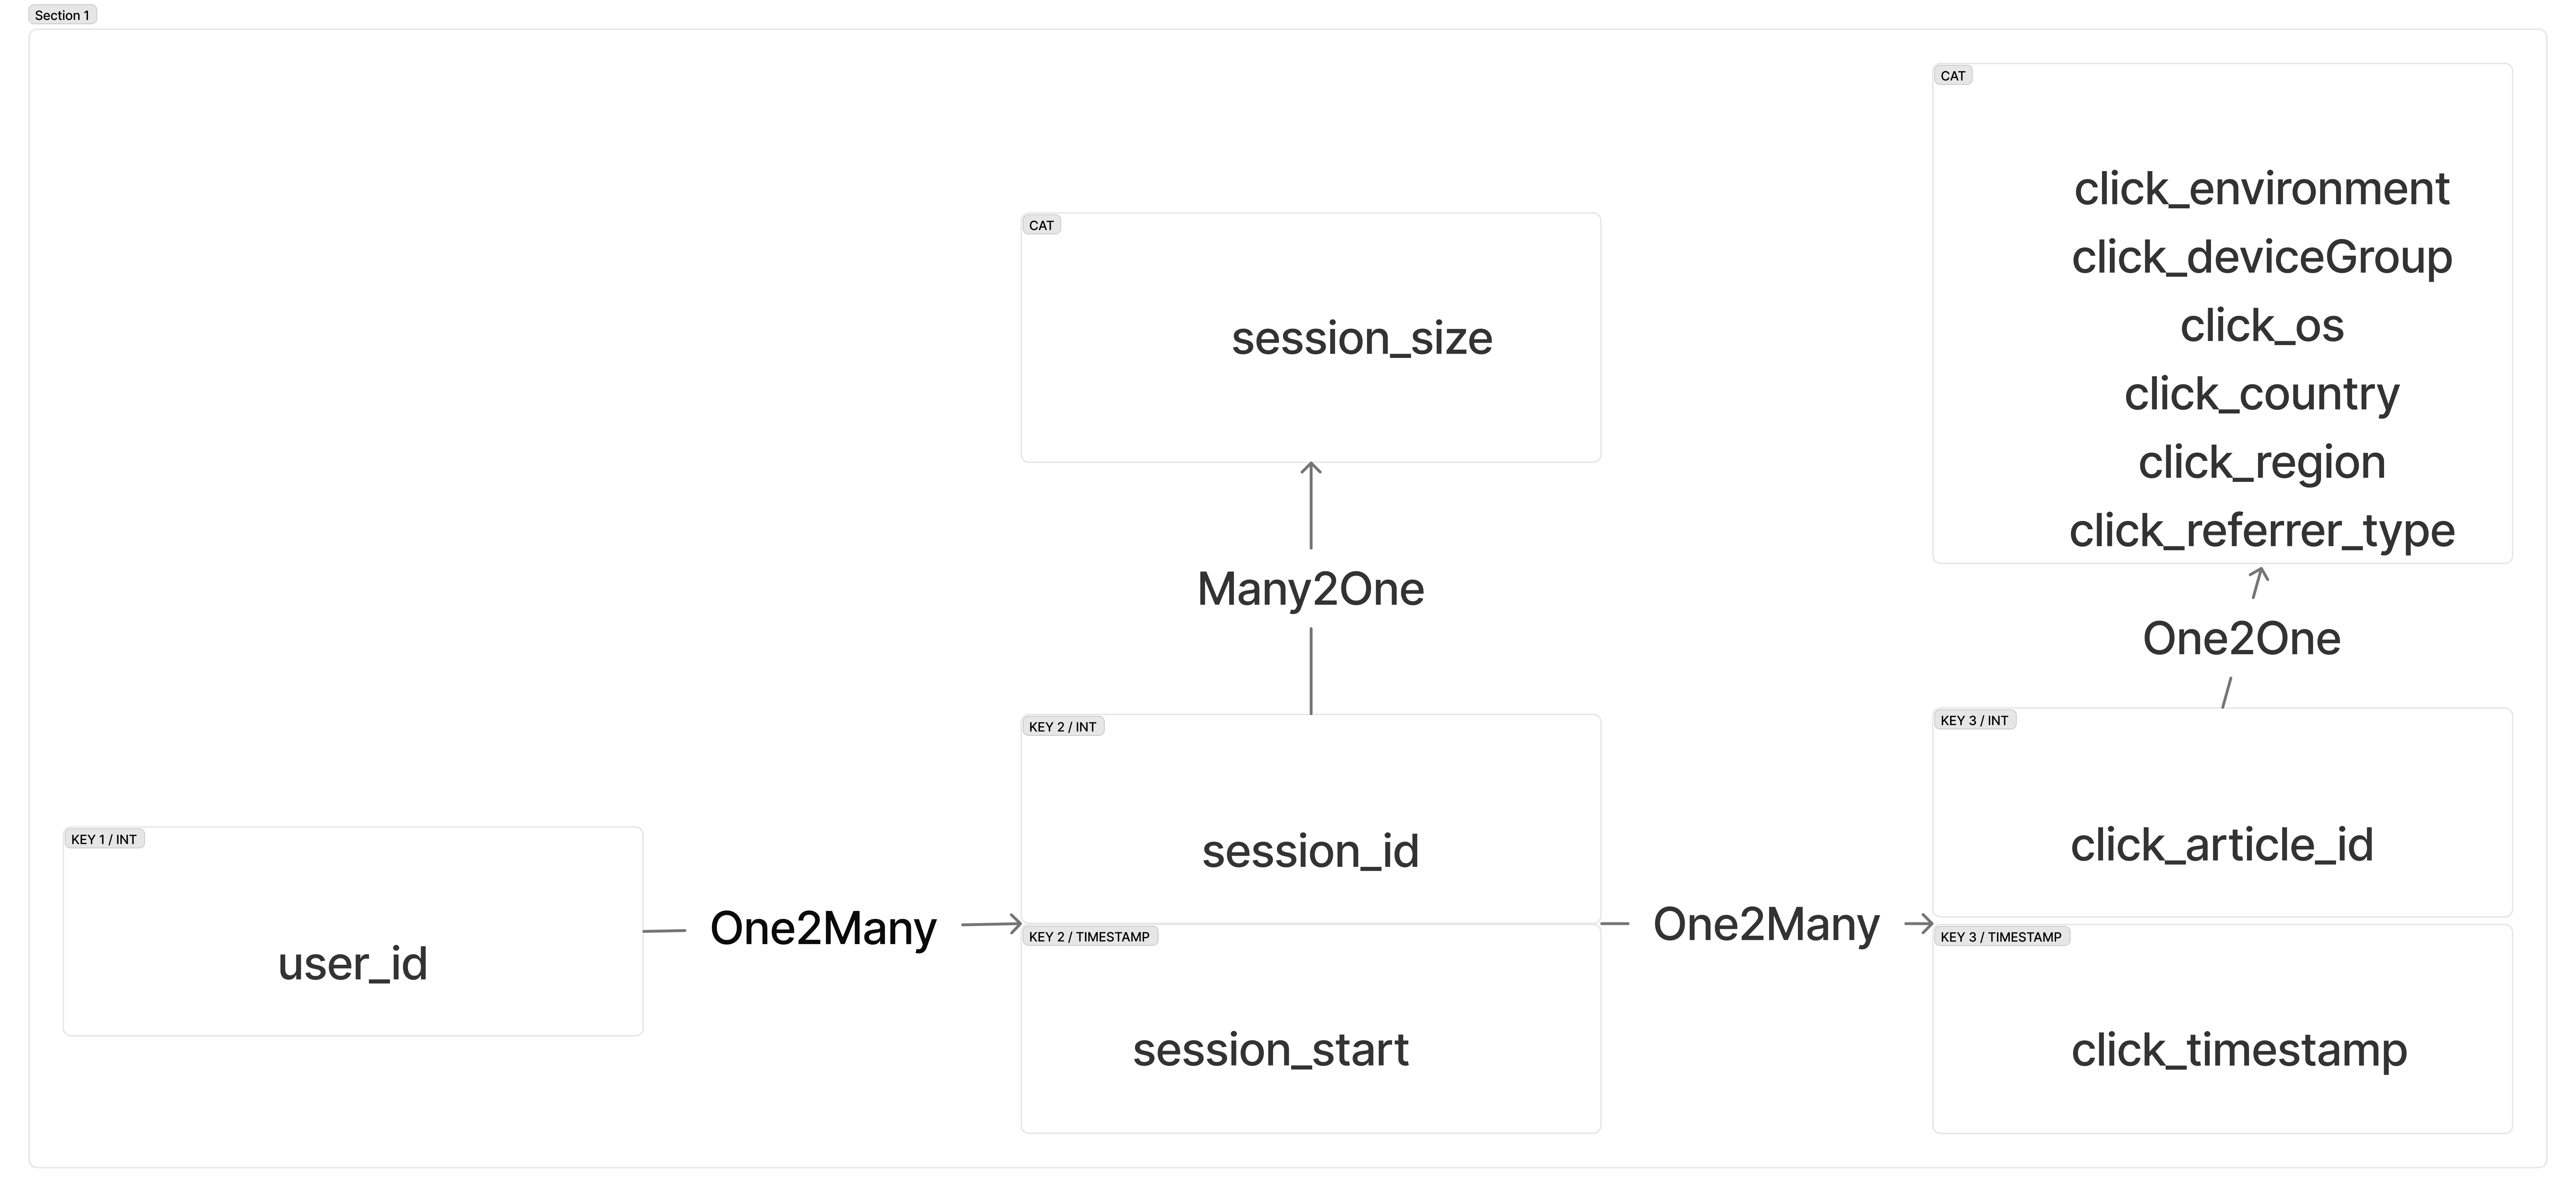

# Metadata

In [36]:
articles_df = pd.read_csv(WORK_DIR / "articles_metadata.csv")

# Fusion des données

In [37]:
merged_df = clicks_df.merge(
    articles_df, left_on="click_article_id", right_on="article_id", how="left"
)
print("Merged DataFrame shape:", merged_df.shape)

Merged DataFrame shape: (2988181, 20)
